In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
from xml.etree import ElementTree
from scipy import stats

import matplotlib.pyplot as plt
# Only works inside notebook
%matplotlib inline 
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000 # assists with processor speed

# Decision Tree and Model Evaluation Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text

# import sklearn.linear_model
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LogisticRegression

# import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import mean_squared_error

# import sklearn.preprocessing
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

# import helper files from local environment
from env import user, password, host
import QMCBT_00_quicktips as qt
import QMCBT_01_acquire as acquire
import QMCBT_02_prepare as prepare
import QMCBT_03_explore as explore
import QMCBT_04_model as model
import QMCBT_05_evaluate as evaluate
import QMCBT_explore_evaluate as ee
import QMCBT_wrangle as w

# Set Alpha
α = Alpha = alpha = 0.05
random_state=1992
np.random.seed(1992)

# allows import reload without needing to clear kernel and rerun
from importlib import reload
# reload(packagename) 

import warnings
warnings.filterwarnings("ignore")

**CUSTOM EXPLORATION FUNCTIONS
nunique_column_all(df): PRINT NUNIQUE OF ALL COLUMNS
nunique_column_objects(df): PRINT NUNIQUE OF COLUMNS THAT ARE OBJECTS
nunique_column_qty(df): PRINT NUNIQUE OF COLUMNS THAT ARE *NOT* OBJECTS
numeric_range(df): COMPUTE RANGE FOR ALL NUMERIC VARIABLES

**USEFUL EXPLORATORY CODE**
DFNAME.head()
DFNAME.shape
DFNAME.shape[0] #read row count
DFNAME.describe().T
DFNAME.columns.to_list()
DFNAME.COLUMNNAME.value_counts(dropna=False)
DFNAME.dtypes
DFNAME.select_dtypes(include='object').columns
DFNAME.select_dtypes(include='float').columns
pd.crosstab(DFNAME.COLUMN-1, DFNAME.COLUMN-2)


In [3]:
# Left Align Tables in Jupyter Notebook
from IPython.core.display import HTML
table_css = 'table {align:left;display:block}'
HTML('<style>{}</style>'.format(table_css))

<div class="alert alert-success">

# Acquire & Prepare:

In [4]:
# Read in csv from local file as leam_df (Life Expectancy And Mortality DataFrame)
leam_df = pd.read_csv('clean_leam.csv', index_col=0)

<div class="alert alert-warning">

## Split

In [5]:
def split(df, stratify=False, target=None):
    """
    This Function splits the DataFrame into train, validate, and test
    then prints a graphic representation and a mini report showing the shape of the original DataFrame
    compared to the shape of the train, validate, and test DataFrames.
    
    IMPORTS Required:
    from sklearn.model_selection import train_test_split
    
    ARGUMENTS:
          df - Input the DataFrame you will split
    stratify - True will stratify for your Target (Do NOT stratify on continuous data)
               False will ignore this function
      target - Only needed if you will stratify
    """
    
    # Do NOT stratify on continuous data
    if stratify:
        # Split df into train and test using sklearn
        train, test = train_test_split(df, test_size=.2, random_state=1992, stratify=df[target])
        # Split train_df into train and validate using sklearn
        train, validate = train_test_split(train, test_size=.25, random_state=1992, stratify=df[target])
        
    else:
        train, test = train_test_split(df, test_size=.2, random_state=1992)
        train, validate = train_test_split(train, test_size=.37, random_state=1992)
    
    # reset index for train validate and test
    train.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    train_prcnt = round((train.shape[0] / df.shape[0]), 2)*100
    validate_prcnt = round((validate.shape[0] / df.shape[0]), 2)*100
    test_prcnt = round((test.shape[0] / df.shape[0]), 2)*100
    
    print('________________________________________________________________')
    print('|                              DF                              |')
    print('|--------------------:--------------------:--------------------|')
    print('|        Train       |      Validate      |        Test        |')
    print(':--------------------------------------------------------------:')
    print()
    print()
    print(f'Prepared df: {df.shape}')
    print()
    print(f'      Train: {train.shape} - {train_prcnt}%')
    print(f'   Validate: {validate.shape} - {validate_prcnt}%')
    print(f'       Test: {test.shape} - {test_prcnt}%')
 
    
    return train, validate, test

In [6]:
train, validate, test = split(leam_df)

________________________________________________________________
|                              DF                              |
|--------------------:--------------------:--------------------|
|        Train       |      Validate      |        Test        |
:--------------------------------------------------------------:


Prepared df: (2208, 10)

      Train: (1112, 10) - 50.0%
   Validate: (654, 10) - 30.0%
       Test: (442, 10) - 20.0%


<div class="alert alert-warning">

## Xy Split

In [7]:
def Xy_split(feature_cols, target, train, validate, test):
    """
    This function will split the train, validate, and test data by the Feature Columns selected and the Target.
    
    Imports Needed:
    from sklearn.model_selection import train_test_split
    
    Arguments Taken:
       feature_cols: list['1','2','3'] the feature columns you want to run your model against.
             target: list the 'target' feature that you will try to predict
              train: Assign the name of your train DataFrame
           validate: Assign the name of your validate DataFrame
               test: Assign the name of your test DataFrame
    """
    
    print('_______________________________________________________________')
    print('|                              DF                             |')
    print('|-------------------:-------------------:---------------------|')
    print('|       Train       |       Validate    |          Test       |')
    print('|-------------------:-------------------:---------------------|')
    print('| x_train | y_train |   x_val  |  y_val |   x_test  |  y_test |')
    print(':-------------------------------------------------------------:')
    
    X_train, y_train = train[feature_cols], train[target]
    X_val, y_val = validate[feature_cols], validate[target]
    X_test, y_test = test[feature_cols], test[target]

    print()
    print()
    print(f'   X_train: {X_train.shape}   {X_train.columns}')
    print(f'   y_train: {y_train.shape}     Index({target})')
    print()
    print(f'X_validate: {X_val.shape}   {X_val.columns}')
    print(f'y_validate: {y_val.shape}     Index({target})')
    print()
    print(f'    X_test: {X_test.shape}   {X_test.columns}')
    print(f'    y_test: {y_test.shape}     Index({target})')
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
feature_cols = ['YEAR','SEX_FMLE','SEX_BTSX',] 
target = 'life_expectancy'

X_train, y_train, X_val, y_val, X_test, y_test = Xy_split(feature_cols, target, train, validate, test)

_______________________________________________________________
|                              DF                             |
|-------------------:-------------------:---------------------|
|       Train       |       Validate    |          Test       |
|-------------------:-------------------:---------------------|
| x_train | y_train |   x_val  |  y_val |   x_test  |  y_test |
:-------------------------------------------------------------:


   X_train: (1112, 3)   Index(['YEAR', 'SEX_FMLE', 'SEX_BTSX'], dtype='object')
   y_train: (1112,)     Index(life_expectancy)

X_validate: (654, 3)   Index(['YEAR', 'SEX_FMLE', 'SEX_BTSX'], dtype='object')
y_validate: (654,)     Index(life_expectancy)

    X_test: (442, 3)   Index(['YEAR', 'SEX_FMLE', 'SEX_BTSX'], dtype='object')
    y_test: (442,)     Index(life_expectancy)


In [9]:
train.head().T

,0,1,2,3,4
YEAR,2019,2015,2019,2019,2015
COUNTRY,MDG,MWI,CAN,KOR,NER
WHOSIS_000001,66.59742,59.67438,80.3959,86.08791,60.2756
WHOSIS_000002,57.73955,52.84434,70.51,74.6607,53.8392
WHOSIS_000007,12.94762,10.92255,18.2056,21.20124,12.49067
WHOSIS_000015,17.3255,14.63438,23.83582,27.8674,16.16279
life_expectancy,38.652523,34.518912,48.23683,52.454312,35.692065
SEX_BTSX,0,0,0,0,0
SEX_FMLE,1,0,0,1,0
SEX_MLE,0,1,1,0,1


<div class="alert alert-success">

# Model:

<div class="alert alert-warning">

## Predictions DataFrame:

In [10]:
predictions = pd.DataFrame({'actual': validate.life_expectancy})
predictions.head()

,actual
0,44.264637
1,42.609115
2,49.878860
3,41.265250
4,35.610018


<div class="alert alert-warning">



## Simple Model

$$ y = mx + b $$

$$y = f(x)$$

In [11]:
from sklearn.linear_model import LinearRegression

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
predictions['simple_lm'] = lm.predict(X_val)

In [12]:
predictions.head()

,actual,simple_lm
0,44.264637,40.930571
1,42.609115,41.023107
2,49.878860,44.296996
3,41.265250,43.588275
4,35.610018,40.939312


### Examine The Model

- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant
- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valuable


In [13]:
# Coefficients & Intercept
lm.coef_, lm.intercept_

(array([0.17718025, 3.273889  , 1.51082808]), -316.70382803644895)

In [14]:
# Human Readable
print('life_expectancy (y) = {:.3f} * Selected Features (X) + {:.3f}'.format(lm.coef_[0], lm.intercept_))

life_expectancy (y) = 0.177 * Selected Features (X) + -316.704


In [15]:
predictions.shape

(654, 2)

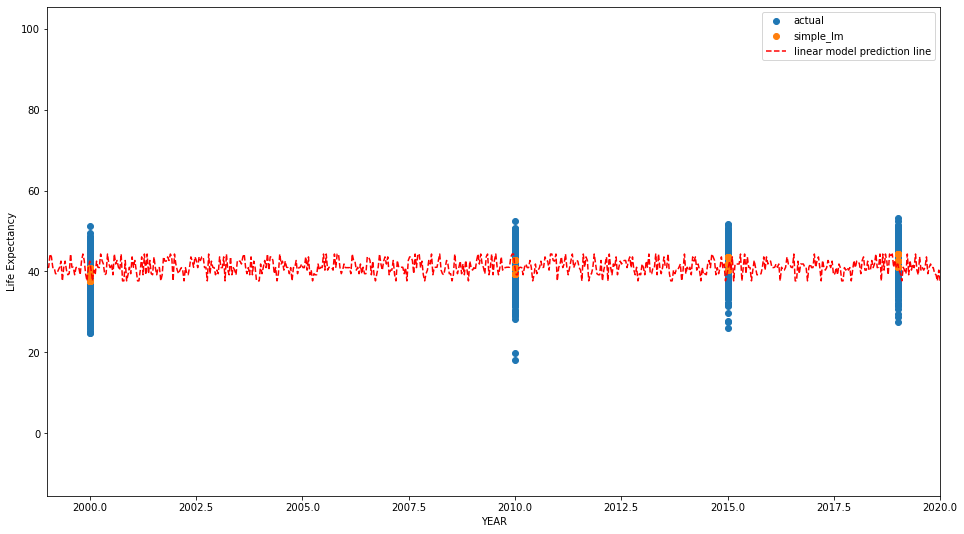

In [16]:
x_pred = np.linspace(1999, 2020, 654)
y_pred = predictions.simple_lm

plt.figure(figsize=(16, 9))
plt.scatter(train.YEAR, train.life_expectancy, label='actual')
plt.scatter(train.YEAR, lm.predict(train[feature_cols]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='red', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')
plt.xlim(1999, 2020)
plt

plt.xlabel('YEAR')
plt.ylabel('Life Expectancy')
plt.legend()

### Model Interpretation

In [17]:
# life_expectancy (y) = 0.177 * [YEAR, SEX_FMLE, SEX_BTSX] (X) + -316.704
print(f'For every 1 year increase in Life Expcetancy, we predict a {lm.coef_[0]:.2f} year increase across Observed Features')

For every 1 year increase in Life Expcetancy, we predict a 0.18 year increase across Observed Features


In [18]:
predictions

,actual,simple_lm
0,44.264637,40.930571
1,42.609115,41.023107
2,49.878860,44.296996
3,41.265250,43.588275
4,35.610018,40.939312
...,...,...
649,32.081648,39.428484
650,39.203695,39.167510
651,27.608877,37.656682
652,48.564900,40.314386


<div class="alert alert-warning">


## Multiple Regression + RFE

$$ y = m_1x_1 + m_2x_2 + b $$

$$ y = f(x1, x2, ...) $$

In [19]:
lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

selected top 2 features: Index(['SEX_FMLE', 'SEX_BTSX'], dtype='object')


In [20]:
X_train.shape

(1112, 3)

In [21]:
X_train_rfe.shape

(1112, 2)

In [22]:
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_val_rfe = rfe.transform(X_val)
predictions['multiple_rfe'] = lm.predict(X_val_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
0,44.264637,40.930571,42.808379
1,42.609115,41.023107,39.598978
2,49.878860,44.296996,42.808379
3,41.265250,43.588275,42.808379
4,35.610018,40.939312,41.238702


### Examine the Model

In [23]:
X_train.columns[rfe.support_]

Index(['SEX_FMLE', 'SEX_BTSX'], dtype='object')

In [24]:
lm.coef_, lm.intercept_

(array([3.20940008, 1.63972307]), 39.598978456873326)

In [25]:
print(f'{target} = {lm.coef_[0]:.2f} x {X_train.columns[rfe.support_][0]} + {lm.coef_[1]:.2f} x {X_train.columns[rfe.support_][1]} + {lm.intercept_:.2f}')

life_expectancy = 3.21 x SEX_FMLE + 1.64 x SEX_BTSX + 39.60


In [26]:
X = pd.DataFrame({
    'SEX_FMLE': [0, 1, 0],
    'SEX_BTSX': [1, 0, 0]
})

X['predicted_life_expectancy'] = lm.predict(X)
X

,SEX_FMLE,SEX_BTSX,predicted_life_expectancy
0,0,1,41.238702
1,1,0,42.808379
2,0,0,39.598978


<div class="alert alert-warning">



## Polynomial Features

First off...what the heck is a polynomial?

$$ y = a_0x^0 + a_1x^1 + a_2x^2 + ... + a_nx^n $$

or a simpler form:

$$ y = a_0 + a_1x + a_2x^2 + ... + a_nx^n $$

`degree = order = n`

What does a polynomial look like when graphed on a coordinate plane? Well it depends on
- The intercept
- The coefficients

Consider this third degree polynomial:

$$ y = 2x + x^3 $$

<div class="alert alert-warning">


## Polynomial Degree 2

In [27]:
# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
X_train_poly.head().T

,0,1,2,3,4
YEAR,2019.0,2015.0,2019.0,2019.0,2015.0
SEX_FMLE,1.0,0.0,0.0,1.0,0.0
SEX_BTSX,0.0,0.0,0.0,0.0,0.0
YEAR^2,4076361.0,4060225.0,4076361.0,4076361.0,4060225.0
YEAR SEX_FMLE,2019.0,0.0,0.0,2019.0,0.0
YEAR SEX_BTSX,0.0,0.0,0.0,0.0,0.0
SEX_FMLE^2,1.0,0.0,0.0,1.0,0.0
SEX_FMLE SEX_BTSX,0.0,0.0,0.0,0.0,0.0
SEX_BTSX^2,0.0,0.0,0.0,0.0,0.0


In [28]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_val_poly = poly.transform(X_val)
predictions['polynomial degree 2'] = lm.predict(X_val_poly)

In [29]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2
0,44.264637,40.930571,42.808379,41.290096
1,42.609115,41.023107,39.598978,41.325406
2,49.878860,44.296996,42.808379,43.980035
3,41.265250,43.588275,42.808379,43.441534
4,35.610018,40.939312,41.238702,40.974954


#### Examine the coefficients of the resulting model.

In [30]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

YEAR SEX_FMLE        -0.075382
YEAR SEX_BTSX        -0.046843
YEAR^2               -0.000463
SEX_FMLE SEX_BTSX     0.000000
YEAR                  2.079220
SEX_BTSX^2           47.857357
SEX_BTSX             47.857357
SEX_FMLE             77.425648
SEX_FMLE^2           77.425648
dtype: float64

<div class="alert alert-warning">


## Polynomial Only Interaction

In [31]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_val_poly = poly.transform(X_val)
predictions['polynomial only interaction'] = lm.predict(X_val_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

YEAR SEX_FMLE         -0.075271
YEAR SEX_BTSX         -0.047128
SEX_FMLE SEX_BTSX      0.000000
YEAR                   0.217294
SEX_BTSX              96.287789
SEX_FMLE             154.628259
dtype: float64

In [32]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction
0,44.264637,40.930571,42.808379,41.290096,41.303182
1,42.609115,41.023107,39.598978,41.325406,41.345527
2,49.878860,44.296996,42.808379,43.980035,44.001611
3,41.265250,43.588275,42.808379,43.441534,43.433521
4,35.610018,40.939312,41.238702,40.974954,40.951165


Takeaway: interaction terms can be useful if you suspect there's a multiplicative relationship between independent variables. Higher order polynomial features should be used with caution (usually when you have domain knowledge that says this is the right thing to do).

Example: Telco churn, using monthly charges and tenure to predict total charges. monthly charges times tenure will give us a good number for total charges.

<div class="alert alert-warning">



## Lasso-Lars

Performs intrinsic feature selection and noise reduction to avoid overfitting.

The most important hyperparameter is `alpha`. 
- `alpha` determines the degree of regularization applied to the model. 
- The lowest `alpha` is zero, and this represents no regularization (identical to OLS). 
- There is no limit to `alpha`, but as it rises, it will reach a point where performance no longer changes (often because you've regularized all of your coefficients to zero. 

Generally speaking, the higher the alpha, the lower your risk for overfitting. 

`alpha` = 1.0 is a good place to start.

In [33]:
from sklearn.linear_model import LassoLars

`alpha = 0`

In [34]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_val_pred_lars = lars.predict(X_val)

In [35]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

YEAR        0.177180
SEX_BTSX    1.510828
SEX_FMLE    3.273889
dtype: float64

`alpha = 0.5`

In [36]:
# create the model object
lars = LassoLars(alpha=0.5)

# fit the model to our training data= 
lars.fit(X_train, y_train)

# predict validate
X_val_pred_lars = lars.predict(X_val)

In [37]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

YEAR        0.0
SEX_FMLE    0.0
SEX_BTSX    0.0
dtype: float64

`alpha = 1.0`

In [38]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_val_pred_lars = lars.predict(X_val)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_val_pred_lars

In [39]:
pd.Series(lars.coef_, index=X_train.columns).sort_values()

YEAR        0.0
SEX_FMLE    0.0
SEX_BTSX    0.0
dtype: float64

In [40]:
lars.intercept_

41.187100240557555

`alpha = 2`

In [41]:
# create the model object
lars_high_alpha = LassoLars(alpha=2)

# fit the model to our training data
lars_high_alpha.fit(X_train, y_train)

# predict validate
X_val_pred_lars_high_alpha = lars.predict(X_val)

In [42]:
pd.Series(lars_high_alpha.coef_, index=X_train.columns).sort_values()

YEAR        0.0
SEX_FMLE    0.0
SEX_BTSX    0.0
dtype: float64

In [43]:
lars_high_alpha.intercept_

41.187100240557555

In [44]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars
0,44.264637,40.930571,42.808379,41.290096,41.303182,41.1871
1,42.609115,41.023107,39.598978,41.325406,41.345527,41.1871
2,49.878860,44.296996,42.808379,43.980035,44.001611,41.1871
3,41.265250,43.588275,42.808379,43.441534,43.433521,41.1871
4,35.610018,40.939312,41.238702,40.974954,40.951165,41.1871


<div class="alert alert-warning">



## Generalized Linear Model (Tweedie)

The most flexible regression algorithm, the GLM allows for different distributions, beyond just the Normal Distribution for OLS (and other models based on OLS, like LASSO). We will use the `TweedieRegressor` method to create a GLM using sklearn.

> `sklearn.linear_model.TweedieRegressor(power=0, alpha=1.0)`

* power = 0: Normal Distribution
* power = 1: Poisson Distribution
* power = (1,2): Compound Distribution
* power = 2: Gamma Distribution
* power = 3: Inverse Gaussian Distribution

In [45]:
from sklearn.linear_model import TweedieRegressor

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
X_val_predict_glm = glm.predict(X_val)

# Add general linear model predictions to our predictions DataFrame
predictions['glm'] = X_val_predict_glm

In [46]:
pd.Series(glm.coef_, index=X_train.columns).sort_values()

YEAR        0.0
SEX_FMLE    0.0
SEX_BTSX    0.0
dtype: float64

In [47]:
glm.intercept_

3.7181251063718017

In [48]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm
0,44.264637,40.930571,42.808379,41.290096,41.303182,41.1871,41.1871
1,42.609115,41.023107,39.598978,41.325406,41.345527,41.1871,41.1871
2,49.878860,44.296996,42.808379,43.980035,44.001611,41.1871,41.1871
3,41.265250,43.588275,42.808379,43.441534,43.433521,41.1871,41.1871
4,35.610018,40.939312,41.238702,40.974954,40.951165,41.1871,41.1871


<div class="alert alert-danger">



### TL;DR

First of all, it always helps to know the distribution of your target variable before modeling.

> `plt.hist(y_train)` to see the shape of your target (`y`).

Secondly, you could try them all...doesn't hurt usually.

Third, if you have a good feel for your data:
- For a normally distributed y and a linear relationship: OLS, LassoLars, GLM(power=0) will work best.
- For polynomial relationships, polynomial regression is best.
- For poisson, gamma or inverse gaussian distributions, use the Generalized Linear Model.

(array([  2.,   2.,  17.,  49., 116., 199., 243., 259., 189.,  36.]),
 array([18.1649    , 21.66903275, 25.1731655 , 28.67729825, 32.181431  ,
        35.68556375, 39.1896965 , 42.69382925, 46.197962  , 49.70209475,
        53.2062275 ]),
 <BarContainer object of 10 artists>)

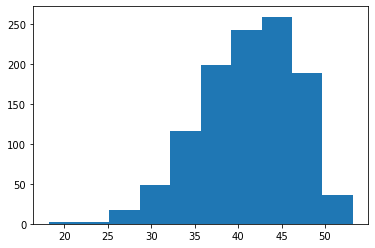

In [49]:
plt.hist(y_train)

<div class="alert alert-success">



# Evaluation

<div class="alert alert-warning">


## Baseline

In [50]:
# add a baseline model
predictions['baseline'] = train.life_expectancy.mean()

In [51]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
0,44.264637,40.930571,42.808379,41.290096,41.303182,41.1871,41.1871,41.1871
1,42.609115,41.023107,39.598978,41.325406,41.345527,41.1871,41.1871,41.1871
2,49.878860,44.296996,42.808379,43.980035,44.001611,41.1871,41.1871,41.1871
3,41.265250,43.588275,42.808379,43.441534,43.433521,41.1871,41.1871,41.1871
4,35.610018,40.939312,41.238702,40.974954,40.951165,41.1871,41.1871,41.1871


<div class="alert alert-warning">


## Calculate mean squared error for every column in the dataframe

In [52]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                          0.000000
simple_lm                      27.561285
polynomial only interaction    27.637088
polynomial degree 2            27.637654
multiple_rfe                   29.480014
lasso_lars                     30.377263
glm                            30.377263
baseline                       30.377263
dtype: float64

In [53]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

# 1. Predict target_pred_mean
target_pred_mean = y_train['life_expectancy'].mean()
y_train['target_pred_mean'] = target_pred_mean
y_val['target_pred_mean'] = target_pred_mean

# 2. compute target_pred_median
target_pred_median = y_train['life_expectancy'].median()
y_train['target_pred_median'] = target_pred_median
y_val['target_pred_median'] = target_pred_median

# 3. RMSE of target_pred_mean
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.target_pred_mean)**(1/2)
rmse_val = mean_squared_error(y_val.life_expectancy, y_val.target_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.target_pred_median)**(1/2)
rmse_val = mean_squared_error(y_val.life_expectancy, y_val.target_pred_median)**(1/2)

print('___________________________________________________________________________________')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2))

RMSE using Mean
Train/In-Sample:  5.54 
Validate/Out-of-Sample:  5.51
___________________________________________________________________________________
RMSE using Median
Train/In-Sample:  5.56 
Validate/Out-of-Sample:  5.53


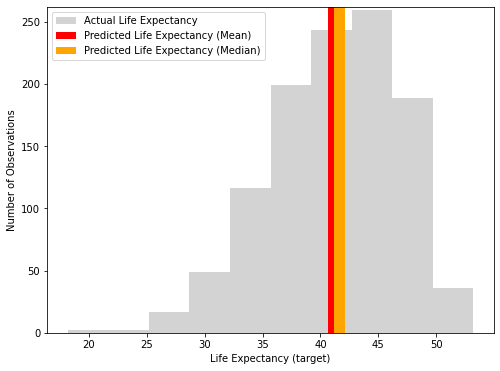

In [54]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(8, 6))
plt.hist(y_train.life_expectancy, color='lightgrey', alpha=1, label="Actual Life Expectancy")
plt.hist(y_train.target_pred_mean, bins=1, color='red', alpha=1, rwidth=100, label="Predicted Life Expectancy (Mean)")
plt.hist(y_train.target_pred_median, bins=1, color='orange', alpha=1, rwidth=100, label="Predicted Life Expectancy (Median)")
plt.xlabel("Life Expectancy (target)")
plt.ylabel("Number of Observations")
plt.ylim(0,262)
plt.legend(loc=2)
plt.show()

<div class="alert alert-danger">



<B><center><font size='80'> Evaluate Best Model on ```Test``` </font></B></center> 
<B><center><font size='10'><i> $(Simple Linear Regression Model)$ ```simple_lm``` </i></font></B></center>

Notice this gets a bit more complicated as we have to reproduce any transformations to the data we did when training. Polynomial transformations need to be applied to the test dataframe to evaluate the polynomial model. 

<div class="alert alert-warning">

## ```metric_TEST``` DataFrame:

In [55]:
metric_TEST = pd.DataFrame({'actual': test.life_expectancy})
metric_TEST.head()

,actual
0,43.866307
1,45.529760
2,42.682560
3,45.892068
4,45.733382


<div class="alert alert-warning">


## Baseline

In [56]:
# add a baseline model
metric_TEST['baseline'] = test.life_expectancy.mean()

<div class="alert alert-warning">



## Simple Model

$$ y = mx + b $$

$$y = f(x)$$

In [57]:
from sklearn.linear_model import LinearRegression

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train.life_expectancy)
# 3. use the thing (make predictions)
metric_TEST['simple_lm_TEST'] = lm.predict(X_test)

# ValueError: Expected a 1D array, got an array with shape (442, 3)

In [58]:
metric_TEST.head()

,actual,baseline,simple_lm_TEST
0,43.866307,41.683862,43.588275
1,45.529760,41.683862,39.428484
2,42.682560,41.683862,39.167510
3,45.892068,41.683862,43.588275
4,45.733382,41.683862,43.588275


### Examine The Model

- **coefficients**: define how our prediction changes as x changes. A one-unit increase in x causes our model to predict a `coef` unit change in y, holding all other independent variables constant
- **intercept**: Value we predict if x is 0. Depending on our x variables, this may not be valuable


In [59]:
# Coefficients & Intercept
lm.coef_, lm.intercept_

(array([0.17718025, 3.273889  , 1.51082808]), -316.70382803644895)

In [60]:
# Human Readable
print('life_expectancy (y) = {:.3f} * Selected Features (X) + {:.3f}'.format(lm.coef_[0], lm.intercept_))

life_expectancy (y) = 0.177 * Selected Features (X) + -316.704


In [61]:
metric_TEST.shape

(442, 3)

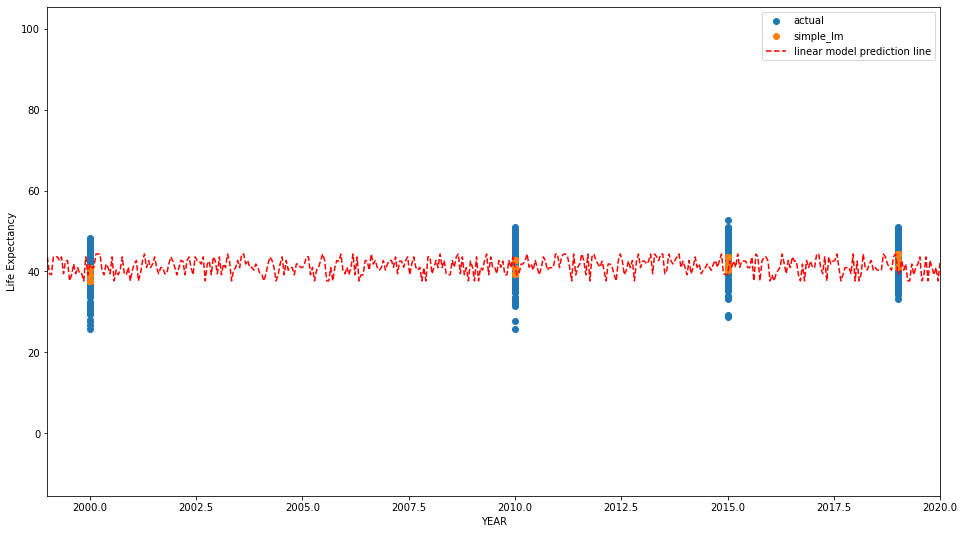

In [62]:
x_pred = np.linspace(1999, 2020, 442)
y_pred = metric_TEST.simple_lm_TEST

plt.figure(figsize=(16, 9))
plt.scatter(X_test.YEAR, test.life_expectancy, label='actual')
plt.scatter(X_test.YEAR, lm.predict(X_test[feature_cols]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='red', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')
plt.xlim(1999, 2020)
plt

plt.xlabel('YEAR')
plt.ylabel('Life Expectancy')
plt.legend()

### Model Interpretation

In [63]:
# life_expectancy (y) = 0.177 * Selected Features (X) + -316.704
print(f'For every 1 year increase in Life Expcetancy, we predict a {lm.coef_[0]:.2f} year increase across Observed Features')

For every 1 year increase in Life Expcetancy, we predict a 0.18 year increase across Observed Features


In [64]:
metric_TEST

,actual,baseline,simple_lm_TEST
0,43.866307,41.683862,43.588275
1,45.529760,41.683862,39.428484
2,42.682560,41.683862,39.167510
3,45.892068,41.683862,43.588275
4,45.733382,41.683862,43.588275
...,...,...,...
437,43.615333,41.683862,40.939312
438,35.012748,41.683862,39.167510
439,48.033218,41.683862,40.930571
440,44.545125,41.683862,37.656682


<div class="alert alert-warning">


## Calculate mean squared error for every column in the dataframe

In [65]:
def calculate_mse(y_predicted):
    return mean_squared_error(metric_TEST.actual, y_predicted)

metric_TEST.apply(calculate_mse).sort_values()

actual             0.000000
simple_lm_TEST    24.127313
baseline          27.778390
dtype: float64

In [66]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

# 1. Predict target_pred_mean
target_pred_mean = y_test['life_expectancy'].mean()
y_train['target_pred_mean'] = target_pred_mean
y_val['target_pred_mean'] = target_pred_mean
y_test['target_pred_mean'] = target_pred_mean


# 2. compute target_pred_median
target_pred_median = y_test['life_expectancy'].median()
y_train['target_pred_median'] = target_pred_median
y_val['target_pred_median'] = target_pred_median
y_test['target_pred_median'] = target_pred_median

# 3. RMSE of target_pred_mean
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.target_pred_mean)**(1/2)
rmse_val = mean_squared_error(y_val.life_expectancy, y_val.target_pred_mean)**(1/2)
rmse_test = mean_squared_error(y_test.life_expectancy, y_test.target_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2),
      "\nTEST/Out-of-Sample: ", round(rmse_test, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.life_expectancy, y_train.target_pred_median)**(1/2)
rmse_val = mean_squared_error(y_val.life_expectancy, y_val.target_pred_median)**(1/2)
rmse_test = mean_squared_error(y_test.life_expectancy, y_test.target_pred_median)**(1/2)

print('___________________________________________________________________________________')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_val, 2),
      "\nTEST/Out-of-Sample: ", round(rmse_test, 2))

RMSE using Mean
Train/In-Sample:  5.57 
Validate/Out-of-Sample:  5.53 
TEST/Out-of-Sample:  5.27
___________________________________________________________________________________
RMSE using Median
Train/In-Sample:  5.67 
Validate/Out-of-Sample:  5.64 
TEST/Out-of-Sample:  5.31


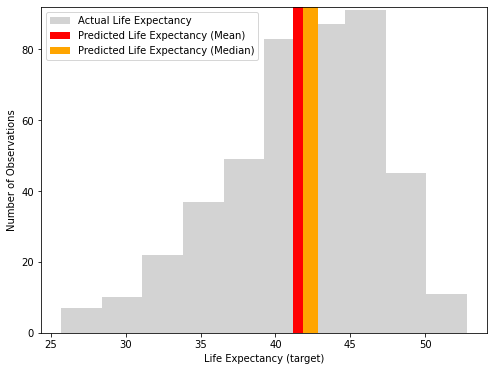

In [67]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(8, 6))
plt.hist(y_test.life_expectancy, color='lightgrey', alpha=1, label="Actual Life Expectancy")
plt.hist(y_test.target_pred_mean, bins=1, color='red', alpha=1, rwidth=100, label="Predicted Life Expectancy (Mean)")
plt.hist(y_test.target_pred_median, bins=1, color='orange', alpha=1, rwidth=100, label="Predicted Life Expectancy (Median)")
plt.xlabel("Life Expectancy (target)")
plt.ylabel("Number of Observations")
plt.ylim(0,92)
plt.legend(loc=2)
plt.show()

<div class="alert alert-danger">



<B><font size='80'><center>STOP HERE</center></font></b>
<center>Project Complete... now go make a pretty presentation!</center>
